In [16]:
import os
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as animation
import matplotlib.colors as mcolors
from scipy.interpolate import interp1d

plt.style.use('matplotlib.mplstyle')

DATA_DIR = 'Data/'
data_name = 'summary.txt'

col_names = ['Step','t','M','LogL','LogR',
             'LogTs','LogTc','Logrhoc','logPc','psic',
             'Xc','Yc','XCc','XNc','XOc',
             'taudyn','tauKH','taunuc','Lpp','LCNO',
             'L3a','LZ','Lv','MHe','MC',
             'MO','RHe','RC','RO']

col_names_structure = ['Mr','r','Lr','P','rho',
                       'T','U','S','Cp','adia1',
                       'nablaad','mu','ne','Pe','Pr',
                       'nablarad','nabla','vc','kappa','epsnuc',
                       'epspp','epscno','eps3alpha','epsvnuc','epsv', 'epsgrav',
                       'X','-','X+','Y', 'Y+', 'Y++', 'XC', 'XN', 'XO', 'Psi']

masses = np.array([0.1, 0.5, 1, 1.5, 2,
                   3, 5, 8, 10, 15,
                   20, 30, 50, 100])

metallicities = np.array([0.0001,0.0003,0.001,0.004,0.01,0.02,0.03])

In [17]:
# Function that adds both P_ion to existing structure file df 

def P_ion(df):
    # Constants
    k = 1.380649e-23 # Boltzmann [J/K]
    m_u = 1.6605e-27 # Atomic mass unit [kg]

    P_ion1 = df['rho']*k*df['T'] / (df['mu']*m_u) # Eq 5
    P_ion2 = df['P'] - df['Pe'] - df['Pr']

    df['Pion1'] = P_ion1
    df['Pion2'] = P_ion2
    
    return df

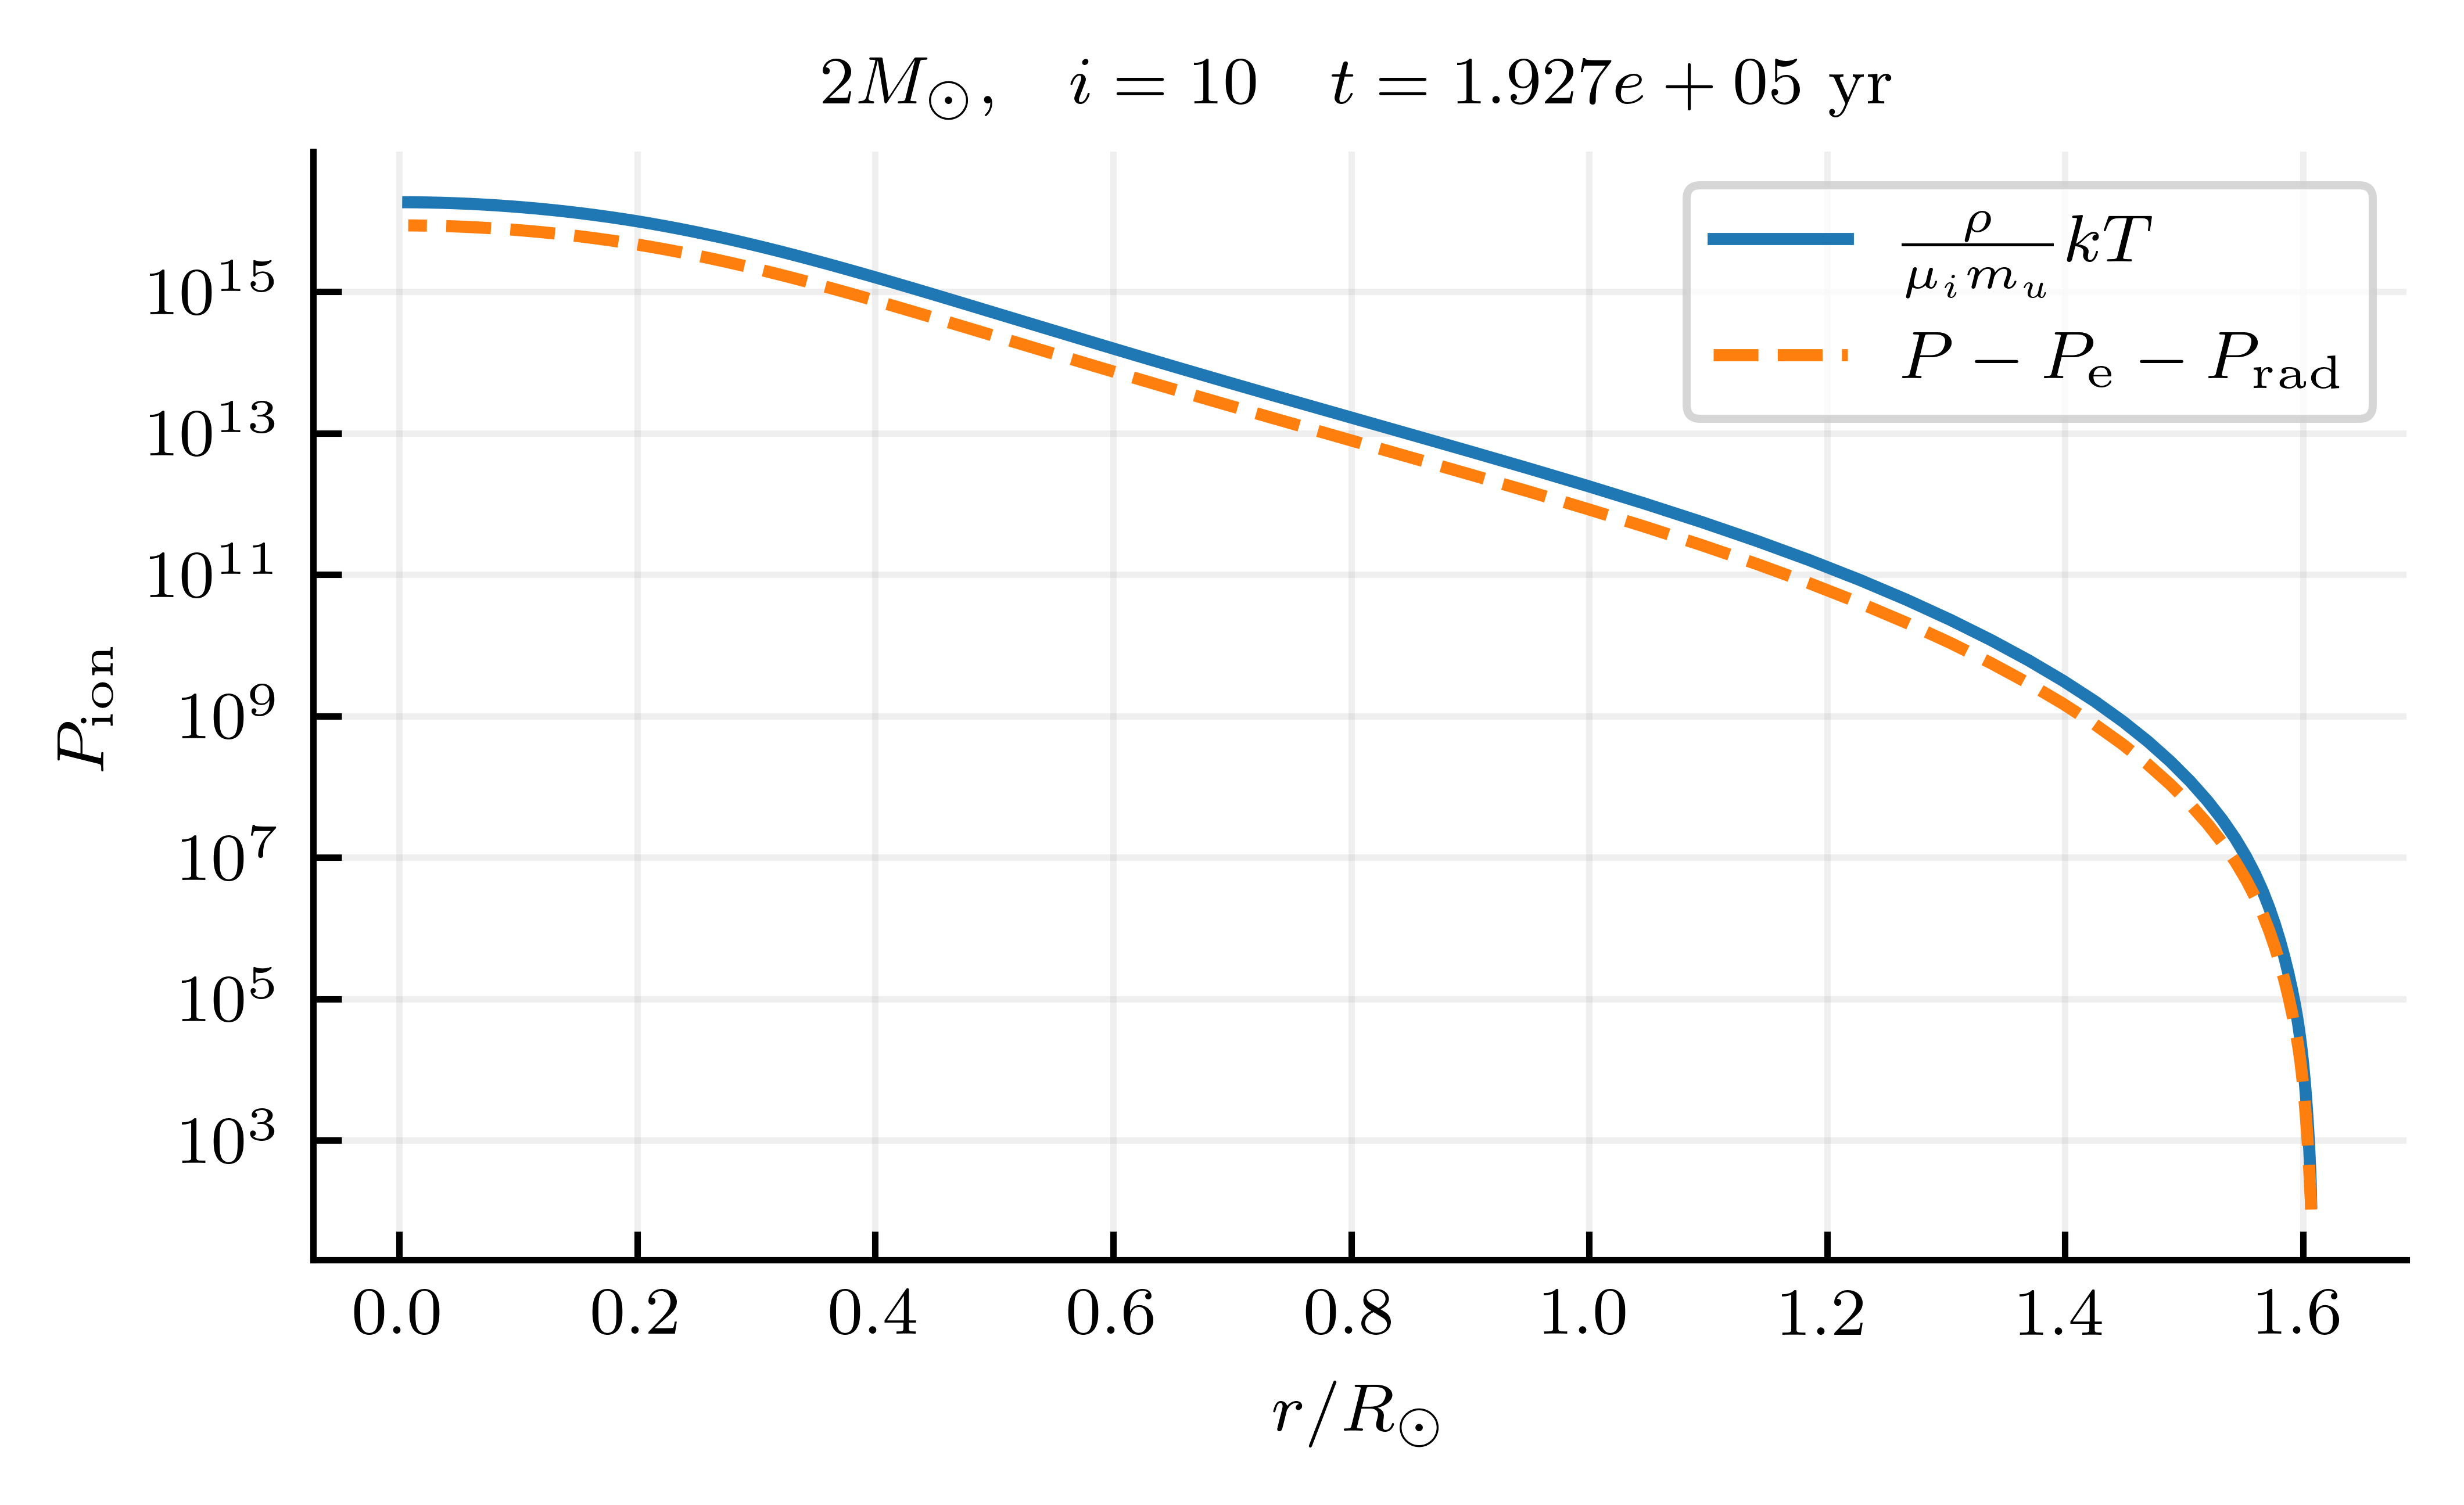

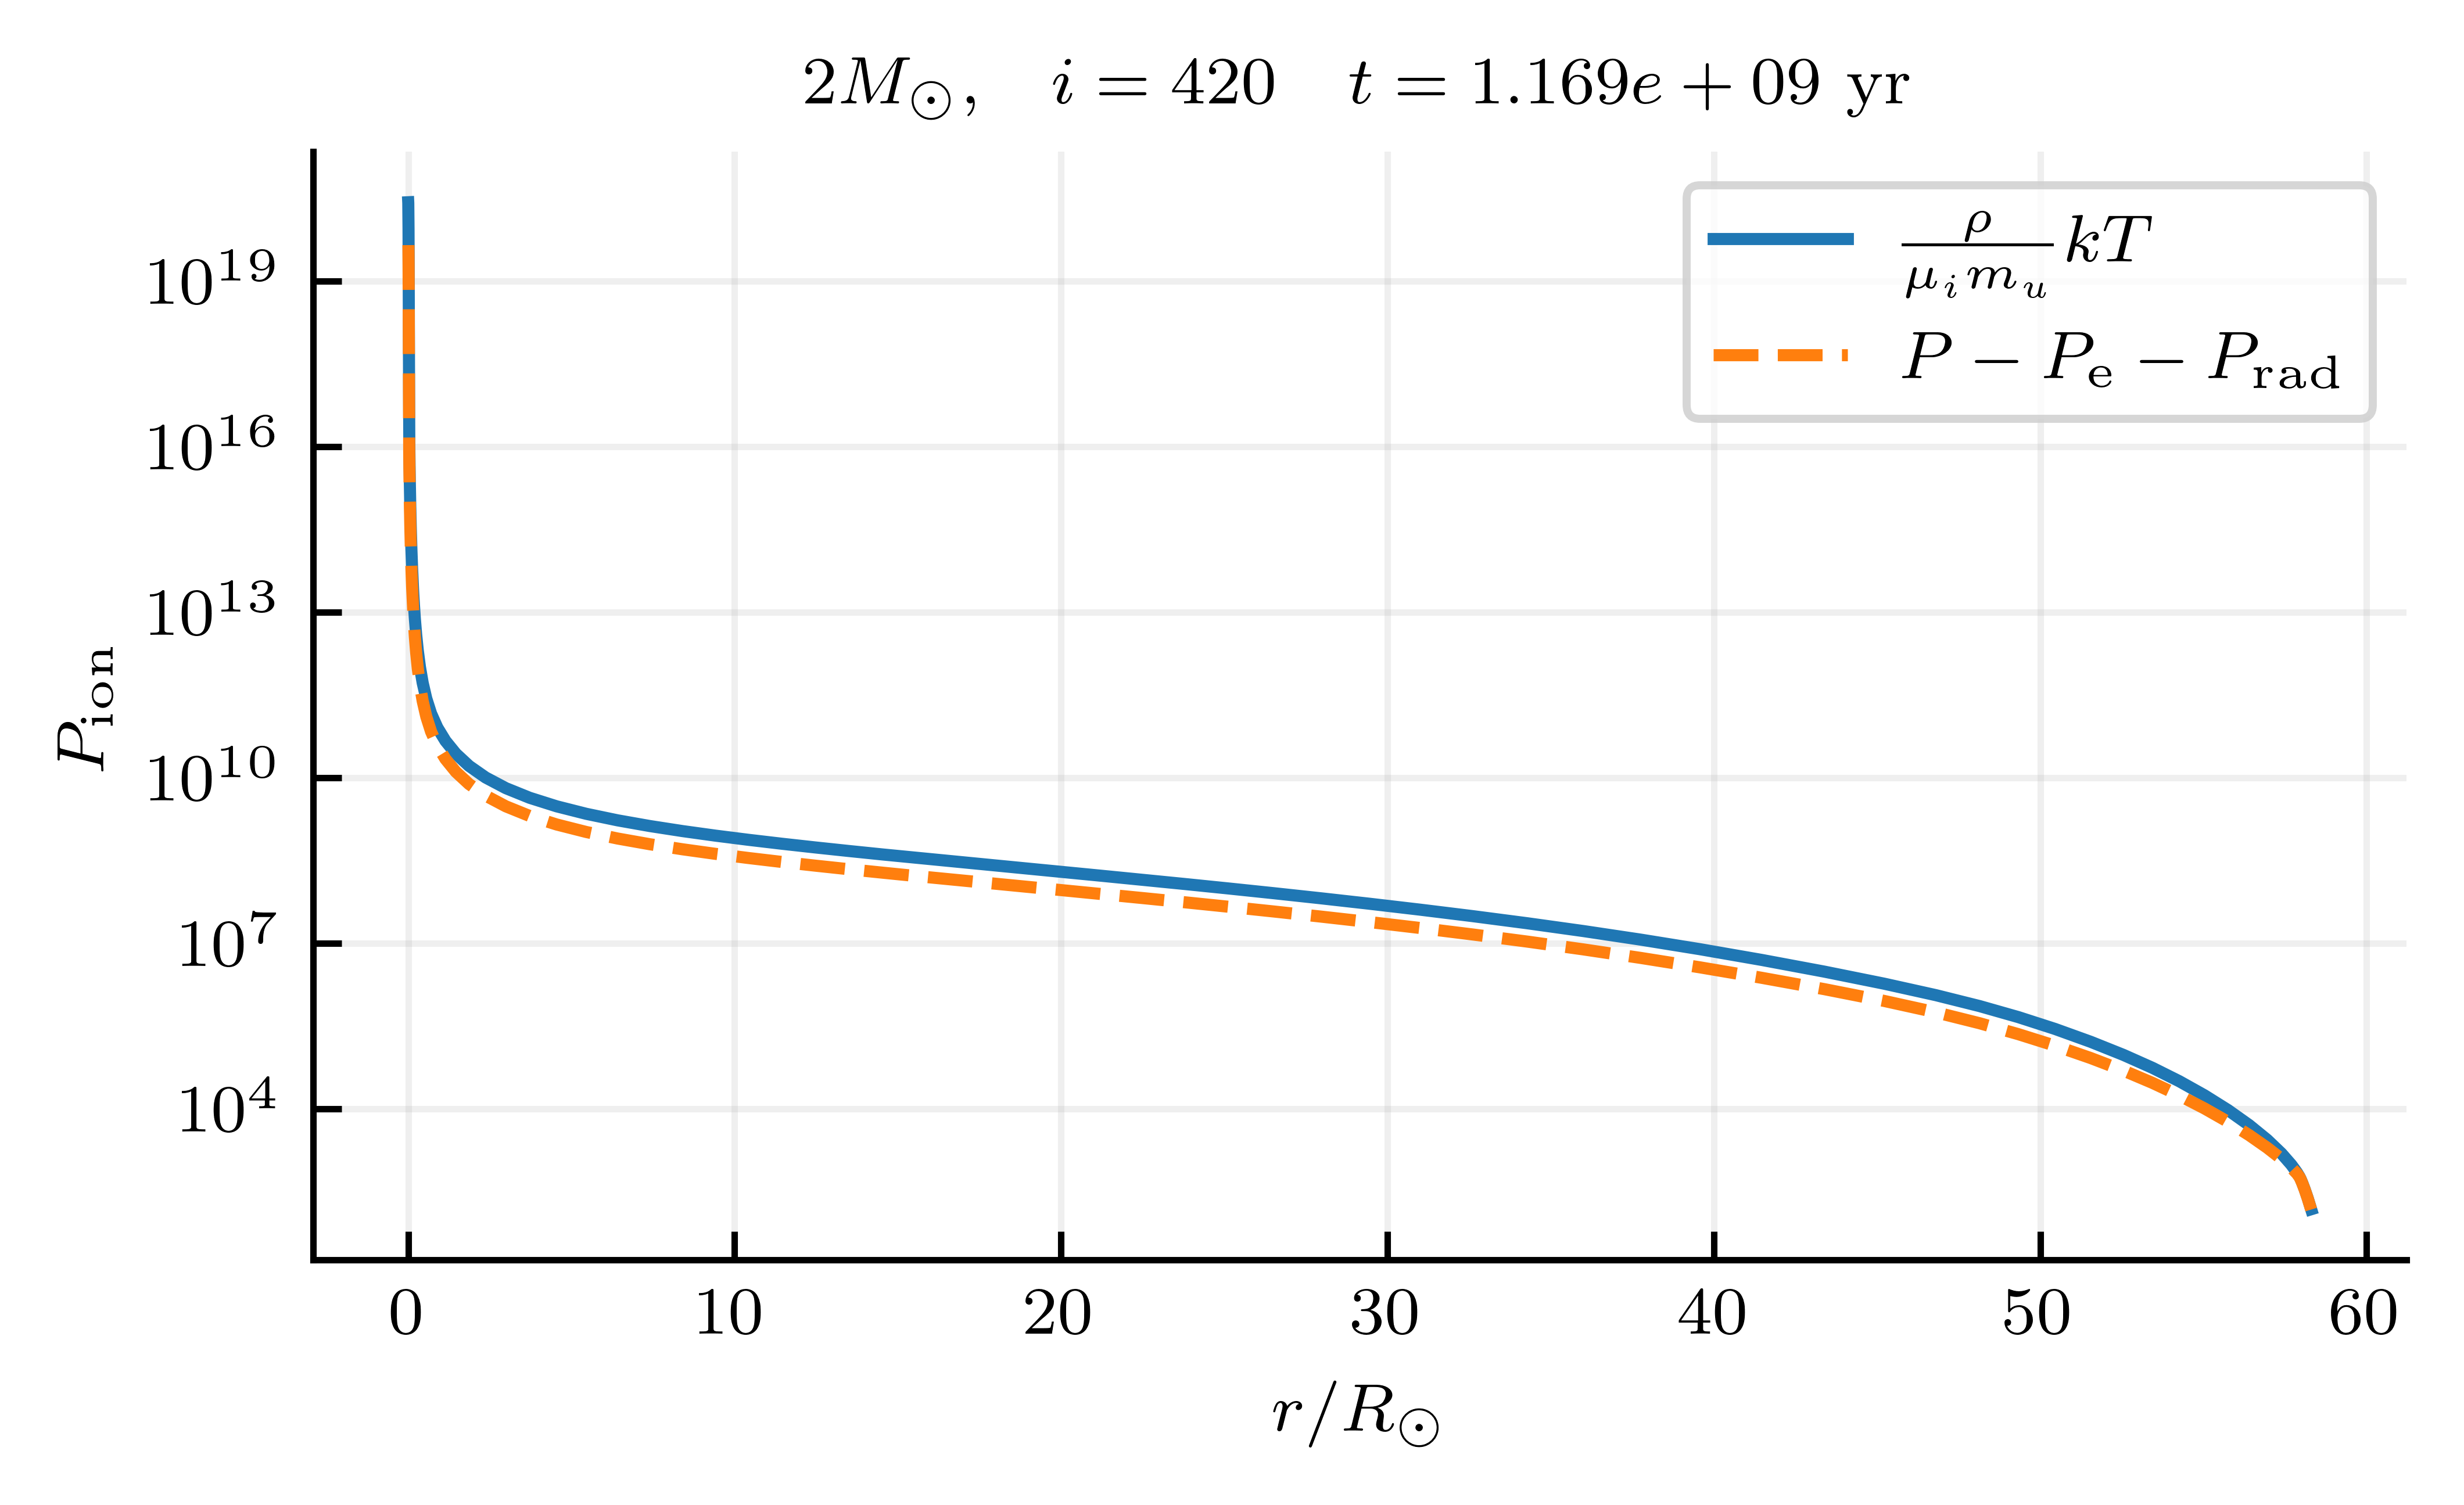

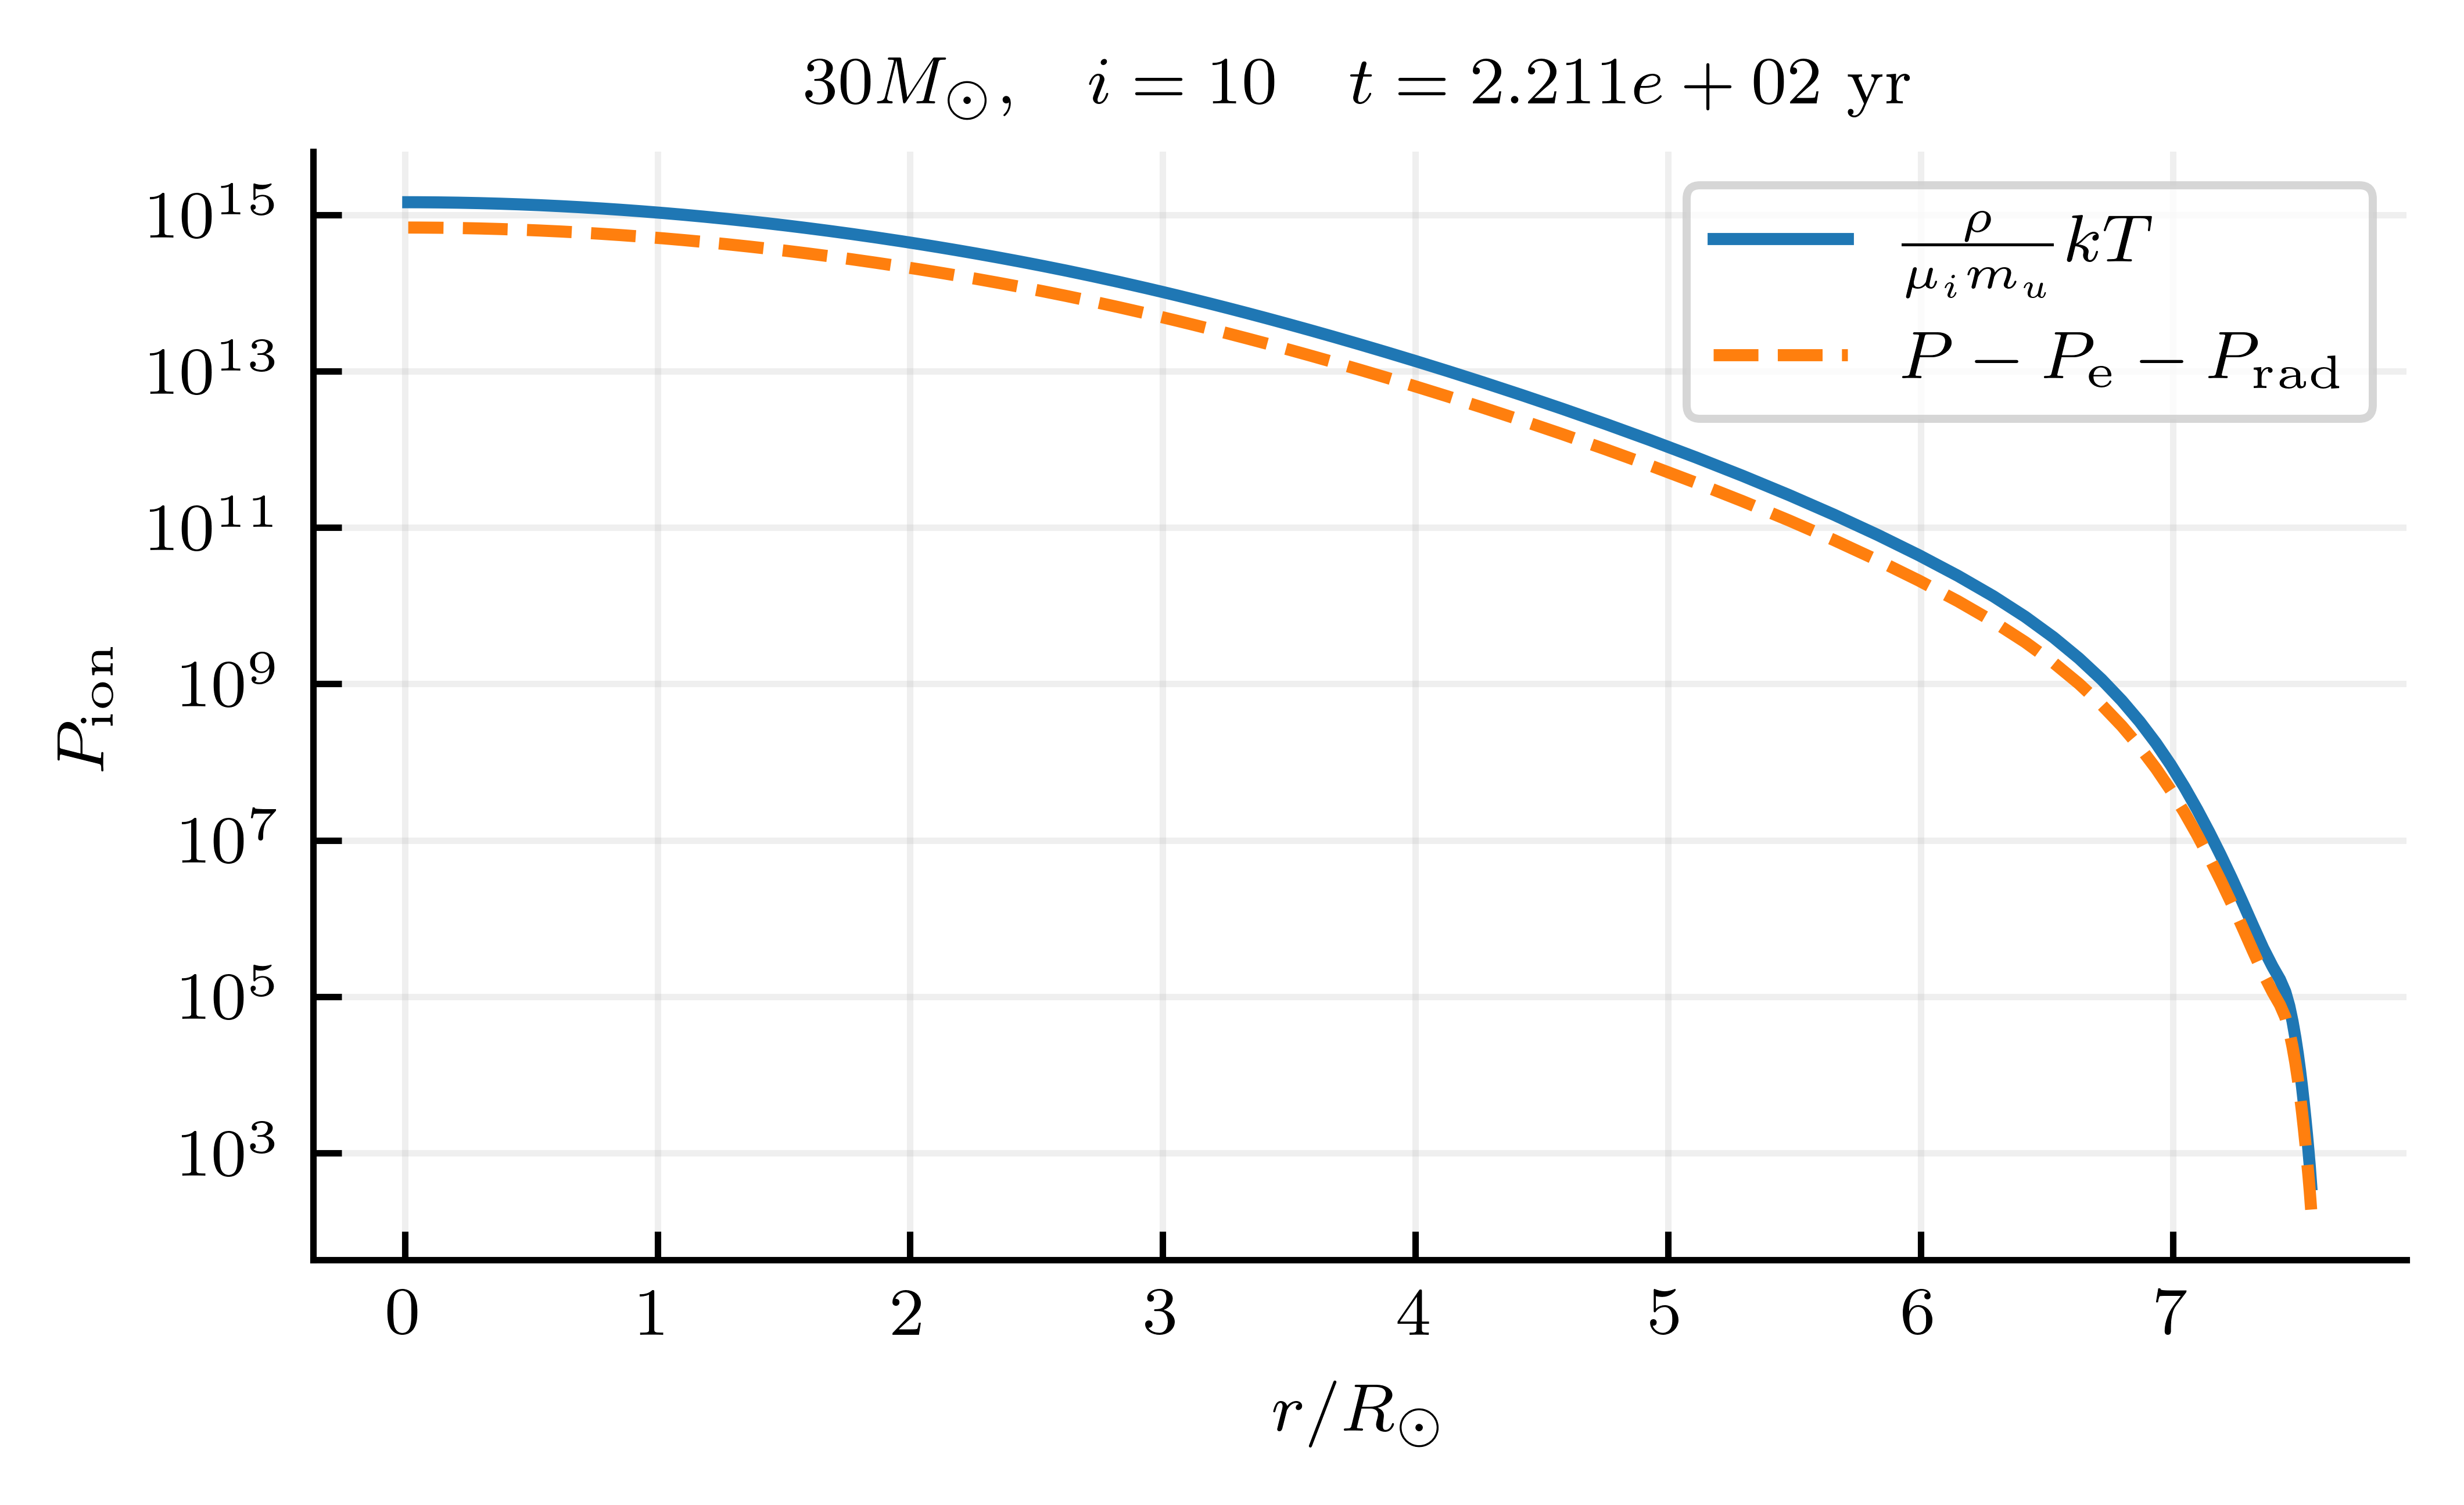

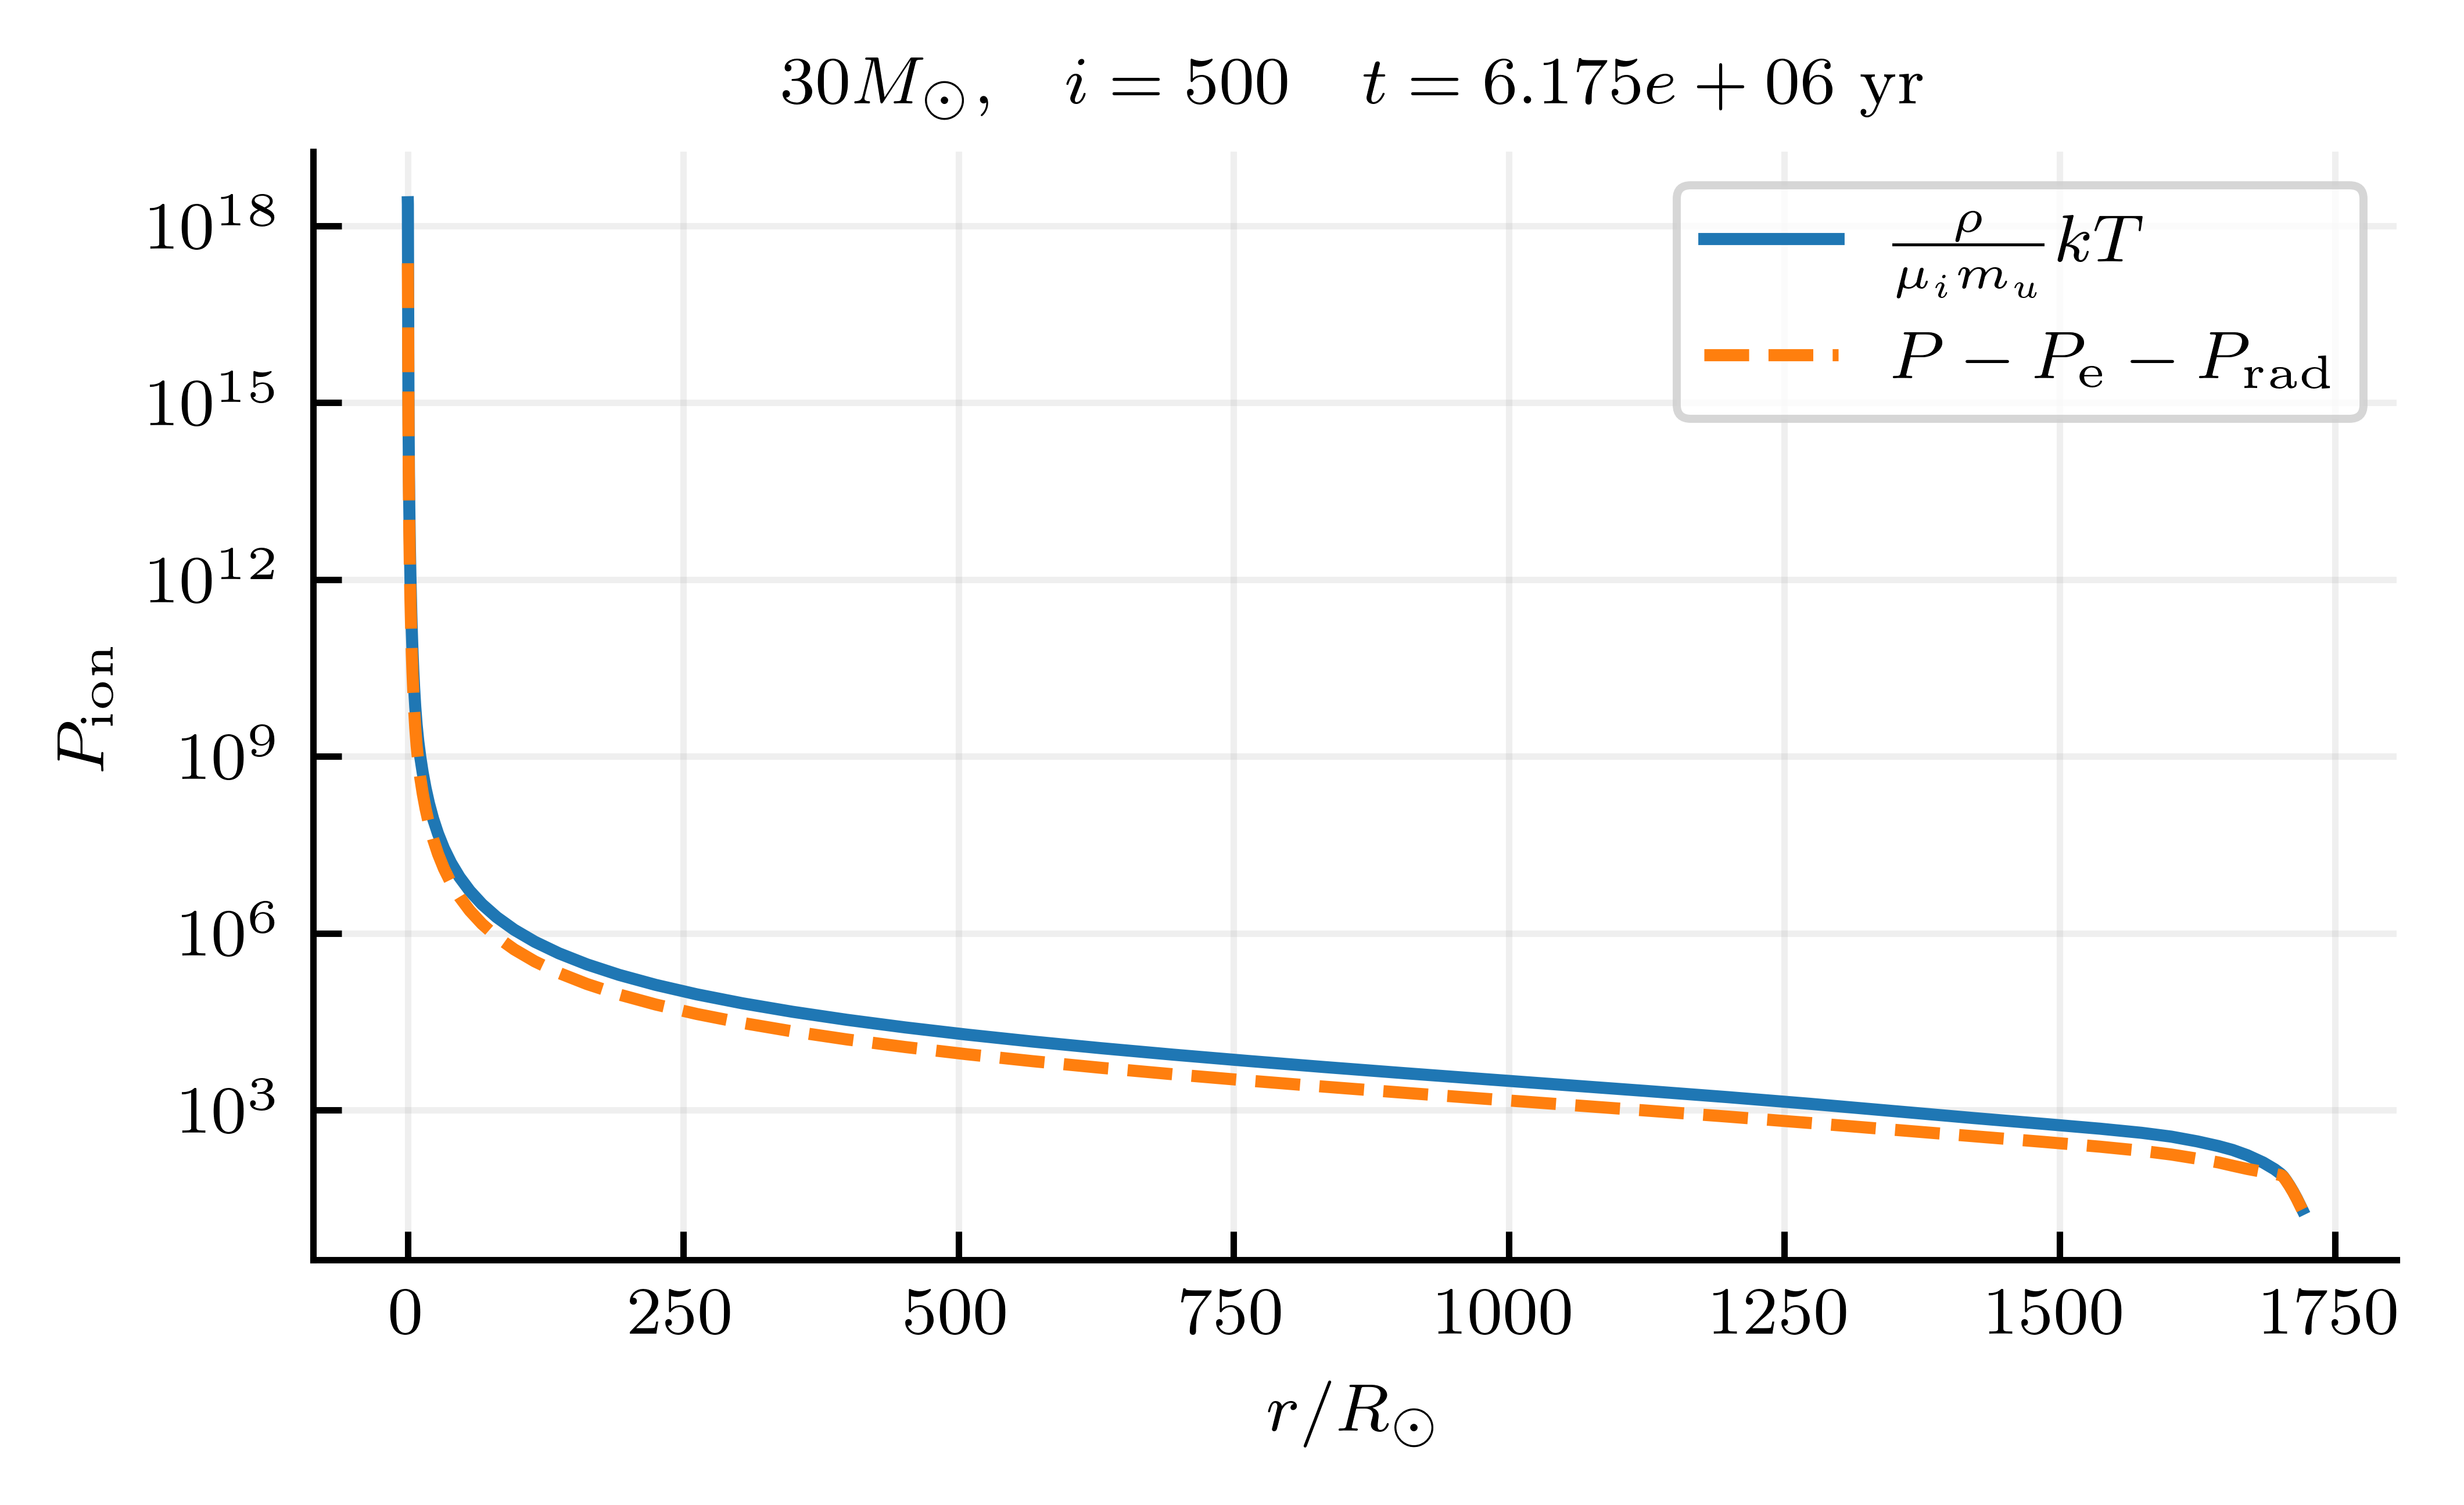

In [18]:
# To-do:
#   - Find "important" times t to investigate (and convert to Step)
#   - Helium, carbon and oxygen core radii could be included

def plot_Pion(mass,metal,step=1):

    fig,ax = plt.subplots() # One plot per mass
        
    cmap = cm.copper
    norm = mcolors.Normalize(vmin=0,vmax=1)

    # Import data and calculate both P_ion
    df = pd.read_csv(DATA_DIR+f'/{mass:.3g}M_{metal:.3g}'+f'/structure_{step:05d}.txt',
                        delim_whitespace=True, header=None)
    df.columns = col_names_structure
    df = P_ion(df)
    
    # Import summary.txt for timestamp
    df_summary = pd.read_csv(DATA_DIR+f'/{mass:.3g}M_{metal:.3g}/summary.txt',
                        delim_whitespace=True, header=None)
    df_summary.columns = col_names
    t = df_summary['t'][step]

    # Plotting
    ax.semilogy(df['r'],df['Pion1'],label=r'$\frac{\rho}{\mu_i m_u}kT$',
                linestyle='-')
    ax.semilogy(df['r'],df['Pion2'],label=r'$P-P_{\mathrm{e}}-P_{\mathrm{rad}}$',
                linestyle='--')
    ax.set_title(f'{mass:.3g}'+r'$M_\odot$,'+rf'$\quad i={step}$'+rf'$\quad t={t:.3e}$ yr')

    ax.legend()
    ax.grid(which='both', alpha=0.2, visible=True)
    ax.set_xlabel(r'$r/R_\odot$')
    ax.set_ylabel(r'$P_\mathrm{ion}$')

metal = 0.02
step = 420 # Which structure file to analyze

plot_Pion(2,0.02,10)
plot_Pion(2,0.02,420) # 420 is past MS
plot_Pion(30,0.02,10)
plot_Pion(30,0.02,500) # 500 is past MS

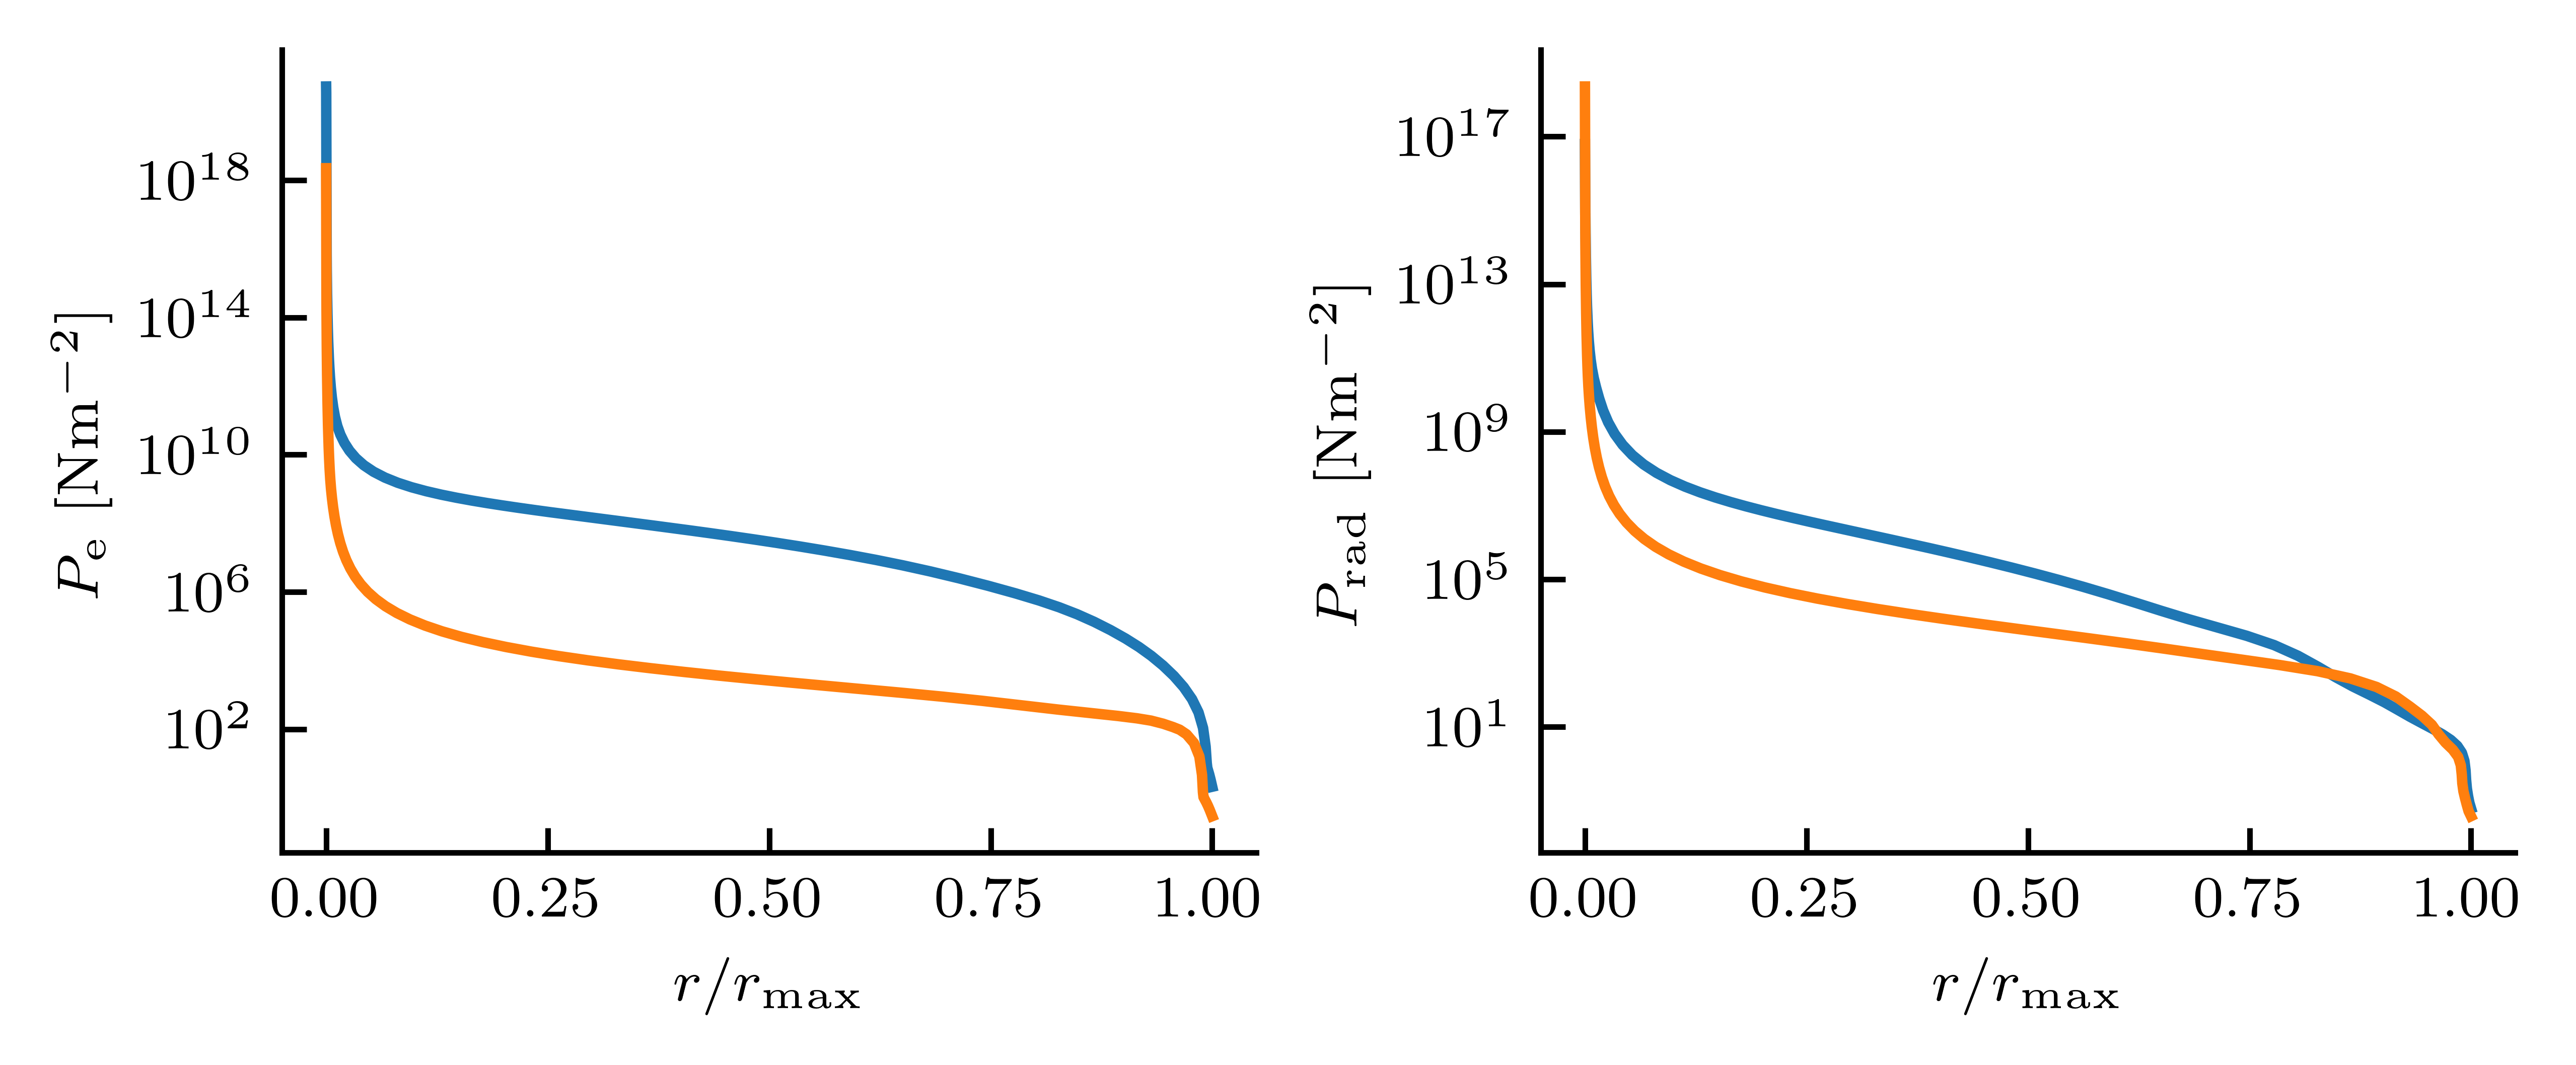

In [19]:
# Examine the differences between electron pressure and radiation
# pressure for stars of different initial mass.

# Instead, separate figs by mass and plot P_X / (P_e + P_rad) since
# actual scale isn't too important

def Pe_Prad(masses,step=1,r_normal=False):

    fig,axs = plt.subplots(1,2,figsize=(5,2))

    for mass in masses:
        df = pd.read_csv(DATA_DIR+f'/3.2/{mass:.3g}M/structure_{step:05d}.txt',
                        delim_whitespace=True, header=None)
        df.columns = col_names_structure

        if r_normal==True:
            r = df['r']/max(df['r'])
            x_label = r'$r/r_\mathrm{max}$'
        else:
            r = df['r']
            x_label = r'$r/R_\odot$'

        axs[0].semilogy(r,df['Pe'])
        axs[0].set_ylabel(r'$P_\mathrm{e} \ [\mathrm{Nm^{-2}}]$')
        axs[0].set_xlabel(x_label)

        axs[1].semilogy(r,df['Pr'])
        axs[1].set_ylabel(r'$P_\mathrm{rad} \ [\mathrm{Nm^{-2}}]$')
        axs[1].set_xlabel(x_label)

        
Pe_Prad([2,30],step=500,r_normal=True)


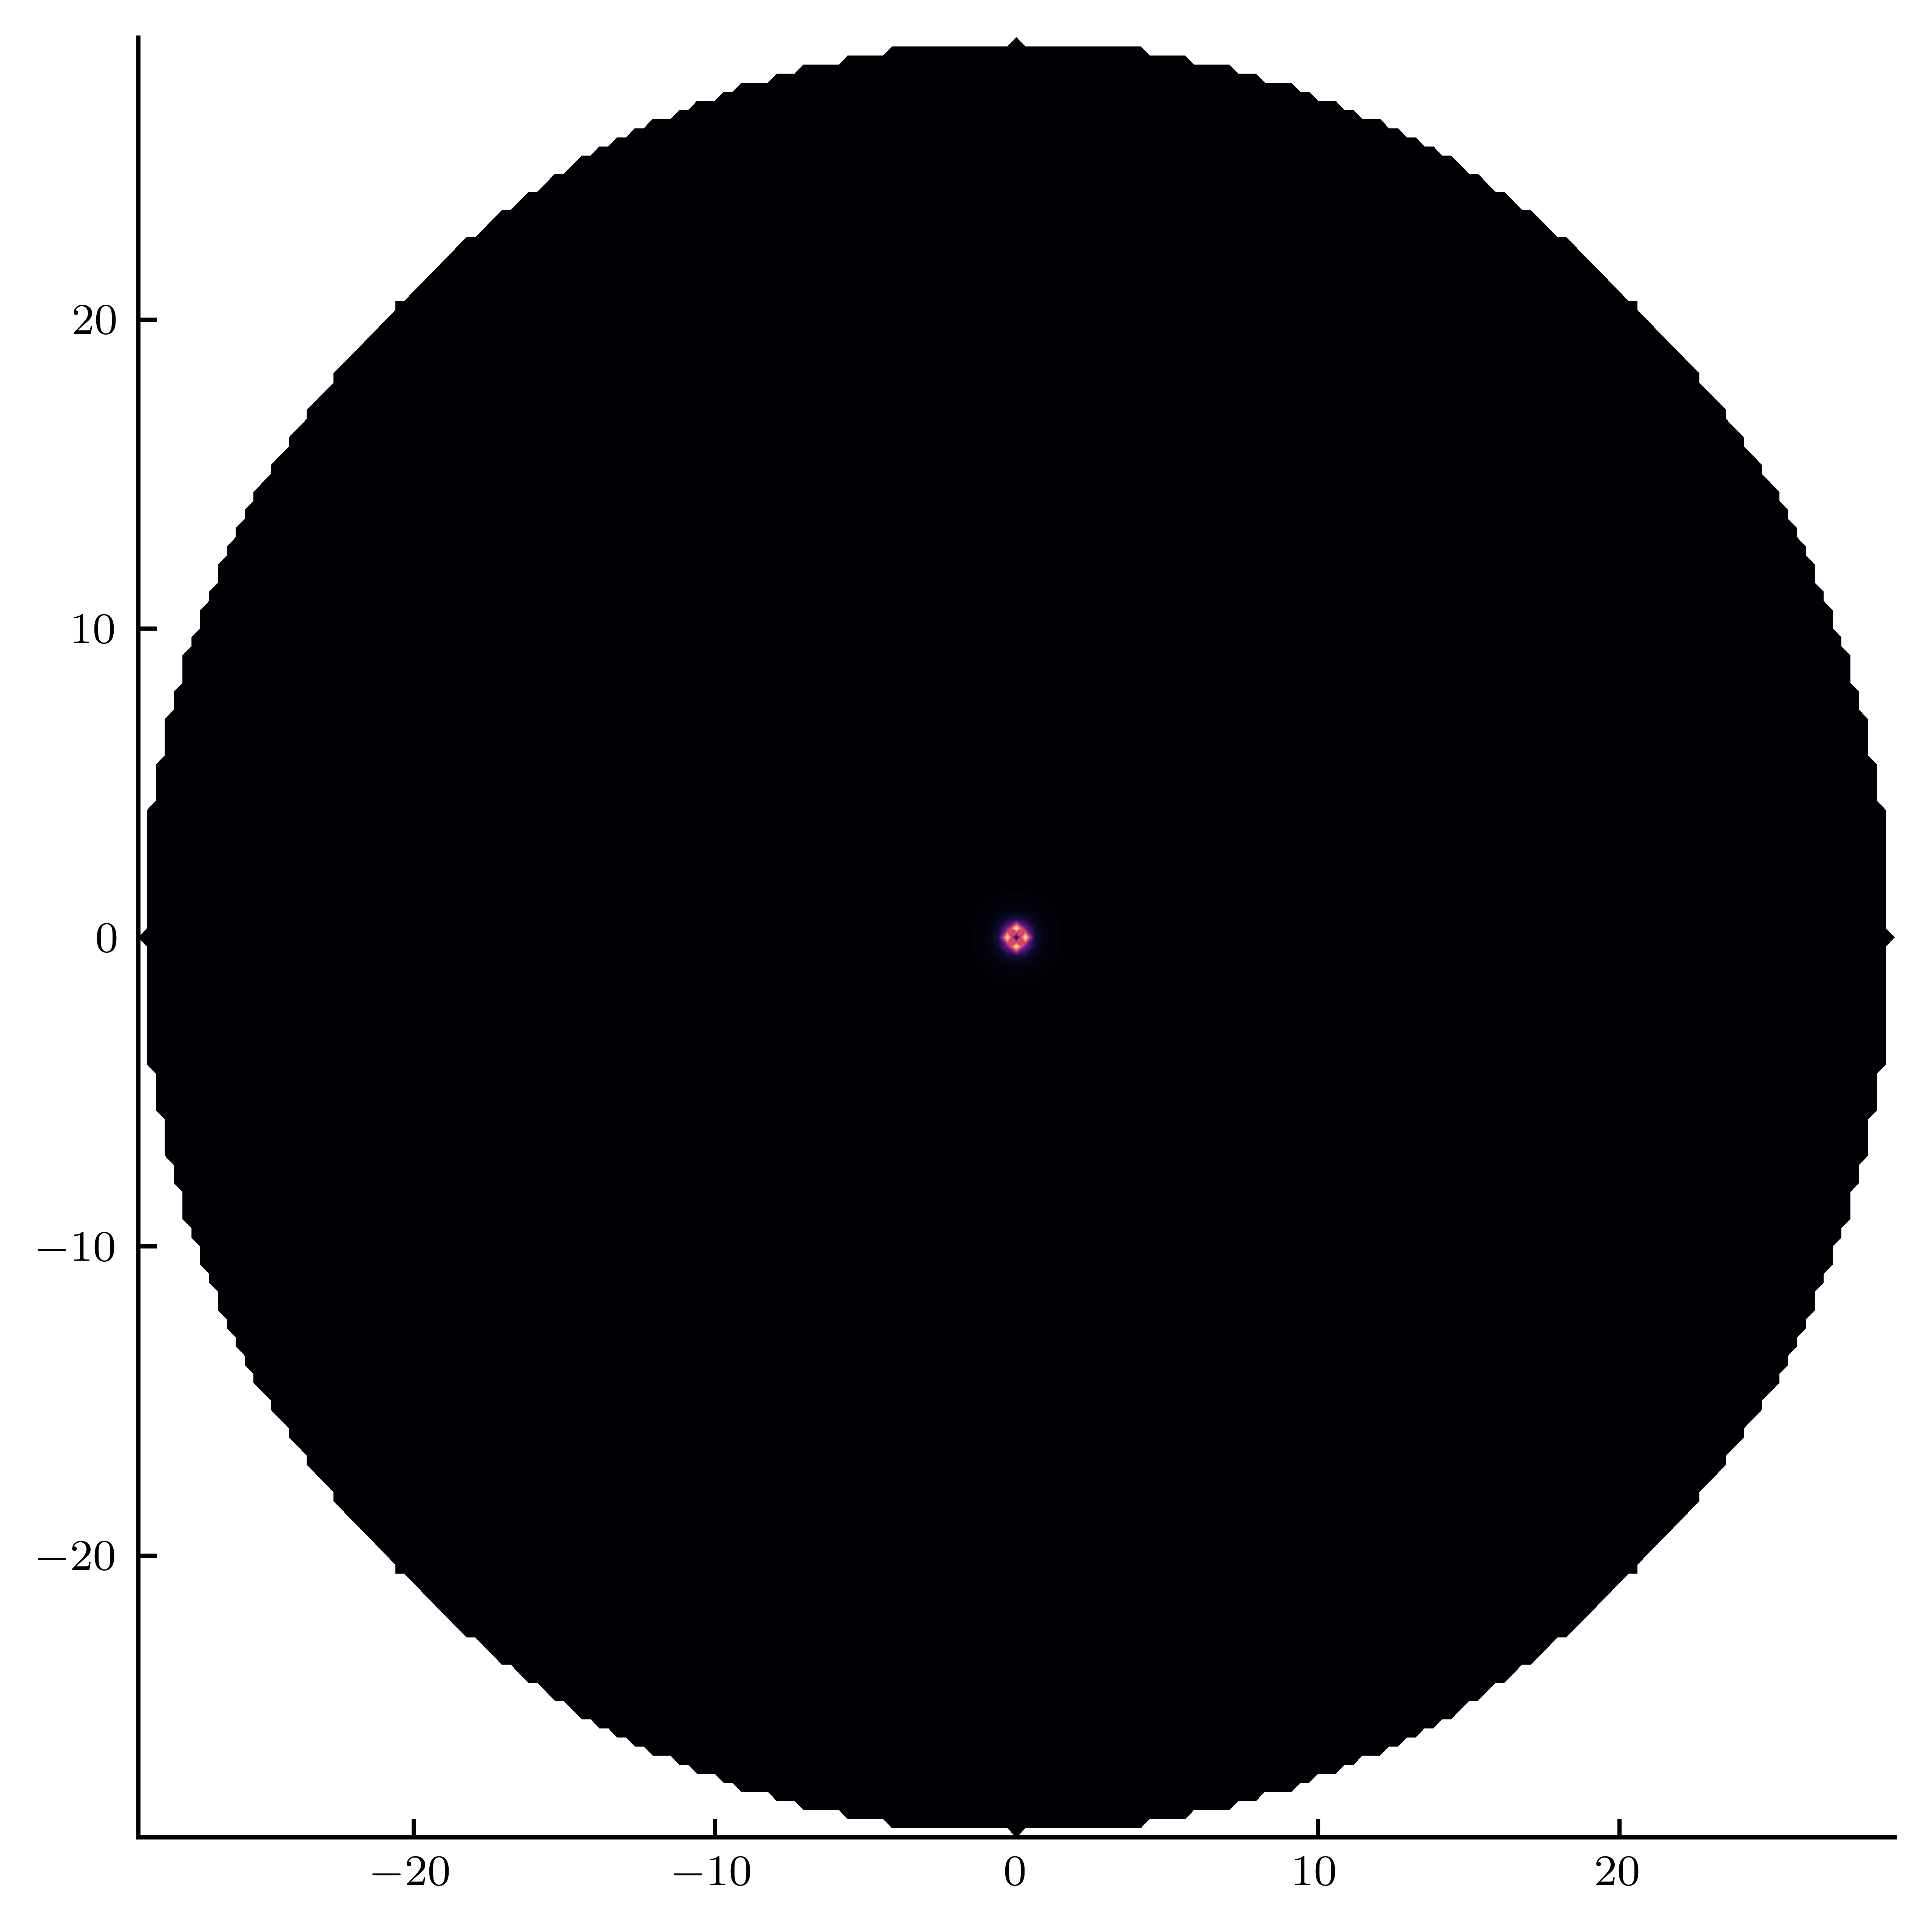

In [21]:
# If we have enough time:
# The pressures could be visualized as circular heatmaps
# (where the circle represents the shape of the star)

def pressure_heatmap(mass,step):
    
    fig,ax = plt.subplots(figsize=(5,5))

    # Import data
    df = pd.read_csv(DATA_DIR+f'/3.2/{mass:.3g}M/structure_{step:05d}.txt',
                        delim_whitespace=True, header=None)
    df.columns = col_names_structure

    r = df['r']
    P_e = df['Pe']
    P_rad = df['Pr']

    # Defining the circle
    r_max = max(r)
    grid_size = 100 # Resolution
    x = np.linspace(-r_max/2,r_max/2,len(r))
    y = np.linspace(-r_max/2,r_max/2,len(r))
    X,Y = np.meshgrid(x,y)
    R_circle = np.sqrt(X**2+Y**2)

    # Plot data onto circle
    interpolation_function = interp1d(r,P_e,bounds_error=False,fill_value=0)
    Z = interpolation_function(R_circle)
    Z[R_circle > r_max/2] = np.nan # No pressure outside the star
    
    ax.contourf(X,Y,Z, levels=grid_size, cmap=cm.magma)

pressure_heatmap(2,500)

Step: 0
Step: 0
Step: 25
Step: 50
Step: 75
Step: 100
Step: 125
Step: 150
Step: 175
Step: 200
Step: 225
Step: 250
Step: 275
Step: 300
Step: 325
Step: 350
Step: 375
Step: 400
Step: 425
Step: 450
Step: 475
Step: 500
Step: 525


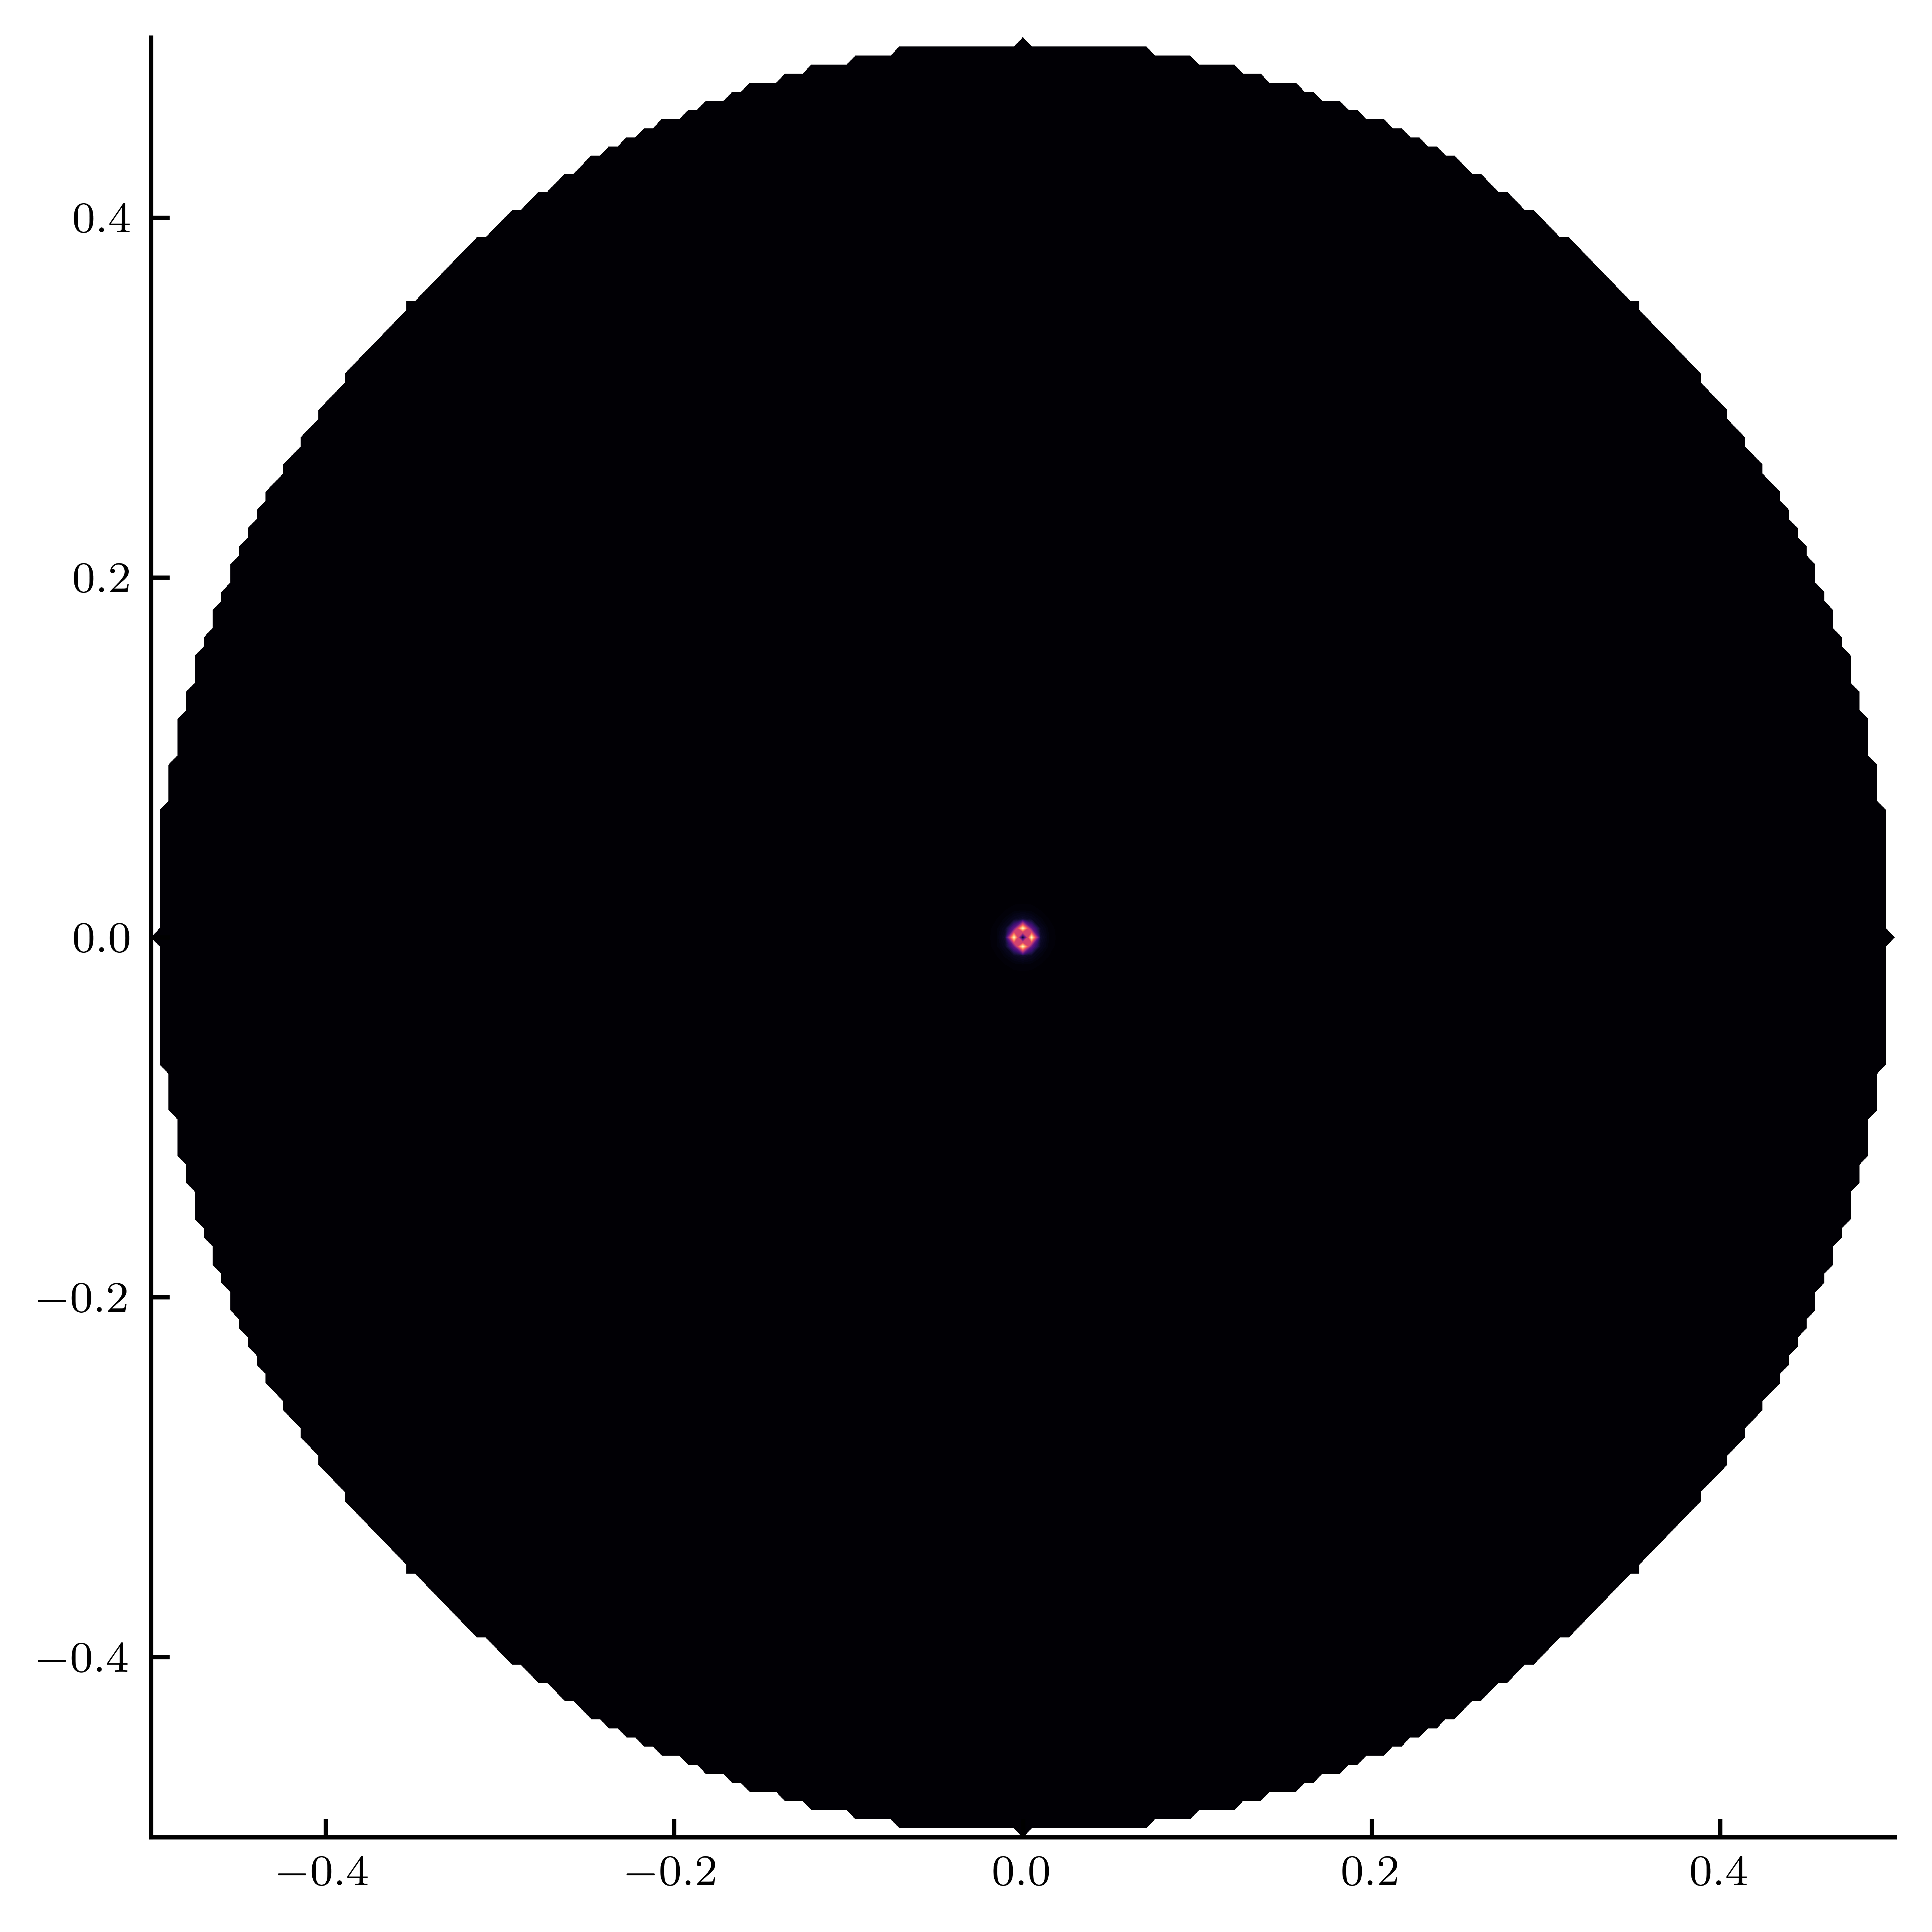

In [34]:
# Heatmap animation
def heatmap_animation(mass,P_type,nth_step):
    if P_type not in {'Pe','Pr'}:
        raise ValueError("P must be 'Pe' or 'Pr'.")
    
    fig,ax = plt.subplots(figsize=(5,5))

    # How many structure files?
    dir = DATA_DIR+f'/3.2/{mass:.3g}M/'
    files = os.listdir(dir)
    structure_files = [f for f in files if f.startswith('structure_') and
                       f.endswith('.txt')]
    steps = len(structure_files)

    # Plot first iteration
    df = pd.read_csv(DATA_DIR+f'/3.2/{mass:.3g}M/{structure_files[0]}',
                    delim_whitespace=True, header=None)
    df.columns = col_names_structure

    P = df[P_type]
    r = df['r']/max(df['r'])

    # Defining the circle
    r_max = max(r)
    grid_size = 100 # Resolution
    x = np.linspace(-r_max/2,r_max/2,len(r))
    y = np.linspace(-r_max/2,r_max/2,len(r))
    X,Y = np.meshgrid(x,y)
    R_circle = np.sqrt(X**2+Y**2)

    # Plot data onto circle
    interpolation_function = interp1d(r,P,bounds_error=False,fill_value=0)
    Z = interpolation_function(R_circle)
    Z[R_circle > r_max/2] = np.nan # No pressure outside the star
    
    ax.contourf(X,Y,Z, levels=grid_size, cmap=cm.magma)

    def update(frame):
        print(f'Step: {frame*nth_step}')
        df = pd.read_csv(DATA_DIR+f'/3.2/{mass:.3g}M/{structure_files[frame*nth_step]}',
                        delim_whitespace=True, header=None)
        df.columns = col_names_structure

        r = df['r']/max(df['r'])
        P = df[P_type]

        # Defining the circle
        r_max = max(r)
        grid_size = 100 # Resolution
        x = np.linspace(-r_max/2,r_max/2,len(r))
        y = np.linspace(-r_max/2,r_max/2,len(r))
        X,Y = np.meshgrid(x,y)
        R_circle = np.sqrt(X**2+Y**2)

        # Plot data onto circle
        interpolation_function = interp1d(r,P,bounds_error=False,fill_value=0)
        Z = interpolation_function(R_circle)
        Z[R_circle > r_max/2] = np.nan # No pressure outside the star
        
        ax.contourf(X,Y,Z, levels=grid_size, cmap=cm.magma)
        #ax.set_xlim([-1,1])
        #ax.set_ylim([-1,1])

        return ax
    
    tot_frames = int(np.floor(steps/nth_step)) + 1

    ani = animation.FuncAnimation(fig, update, frames=tot_frames, interval=50,
                                  repeat = True)
    ani.save(f'Results/3.5/Pressure animation {mass:.3g}M {P_type}.gif',
             writer=animation.PillowWriter(fps=5))

heatmap_animation(30,'Pe',25)

In [7]:
stepsx = 90
nth = 8

print(np.floor(stepsx/nth))

11.0
